## 0. Notebook description

Based on the findings of the previous notebooks, this notebook uses the baseline 5 convolutional layer model, with extra FER2013 images generated from the FER2013 datasest. We load the trained model, and fine tune it on the GAN-generated images using transfer learning.

## 1. Importing libraries and loading the data

In [1]:
# Import Libraries
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.tensorboard import SummaryWriter
from sklearn.metrics import classification_report
from utils.preprocessing import oversample_data, load_data, ReshapeAndScale, create_dataloaders
from utils.fer2013_dataset import Fer2013Dataset

First, we load the GAN-generated images into a pandas dataframe.

In [2]:
train_df = load_data("data/gan_images_300_epochs.csv")
train_df


emotion                                             pixels
0            0  8 10 16 18 31 43 50 64 82 113 134 155 169 183 ...
1            0  24 50 88 154 237 249 250 248 247 249 249 247 2...
2            0  115 219 178 54 7 0 0 0 0 0 0 0 0 0 0 0 0 0 2 8...
3            0  0 1 4 3 6 6 9 10 9 9 14 18 17 16 19 30 58 91 1...
4            0  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...
...        ...                                                ...
13995        6  196 187 144 135 76 124 95 106 94 117 102 77 49...
13996        6  171 75 39 87 56 67 69 92 70 90 102 125 121 134...
13997        6  0 0 0 0 0 0 0 3 14 62 126 160 166 183 179 180 ...
13998        6  108 95 63 89 46 54 45 62 50 74 84 107 86 99 10...
13999        6  5 5 2 8 3 4 2 4 6 8 6 6 7 11 10 17 28 44 46 57...

[14000 rows x 2 columns]

## 1a. Inspect the GAN images

In this section, we visualize 100 images from each label generated by the GAN. We will omit labels-image sets where the generator has not been able to recreate the emotion with any realism.  

Displaying 100 images for emotion: Angry


<Figure size 1400x1400 with 0 Axes>

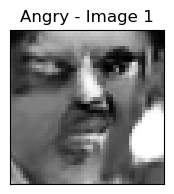

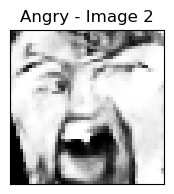

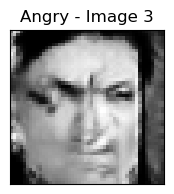

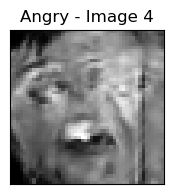

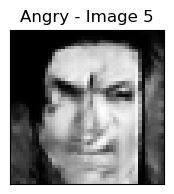

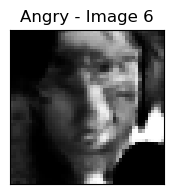

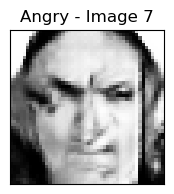

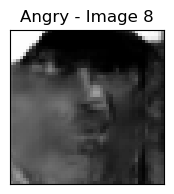

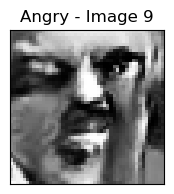

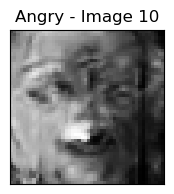

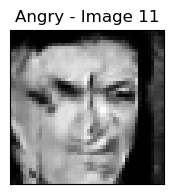

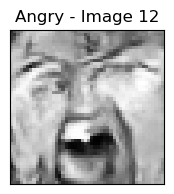

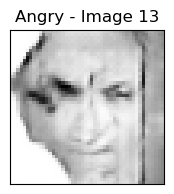

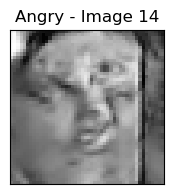

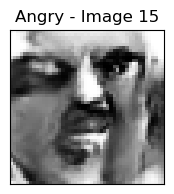

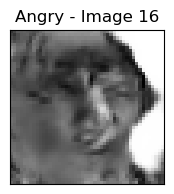

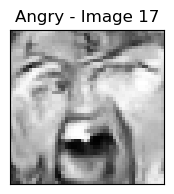

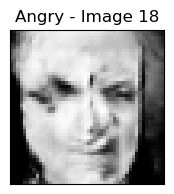

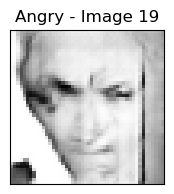

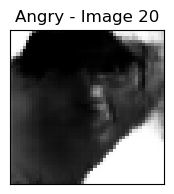

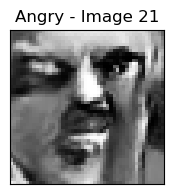

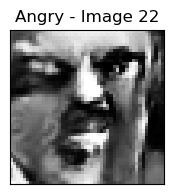

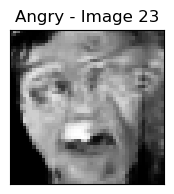

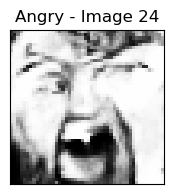

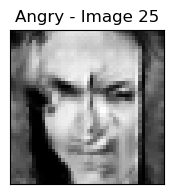

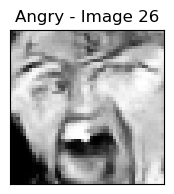

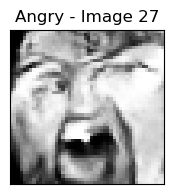

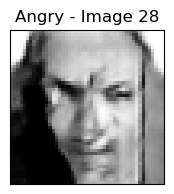

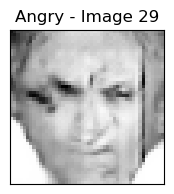

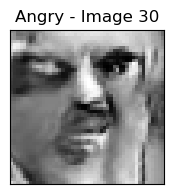

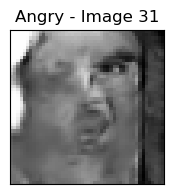

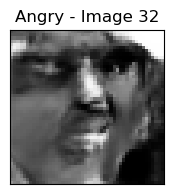

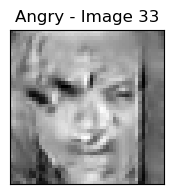

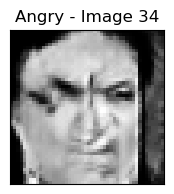

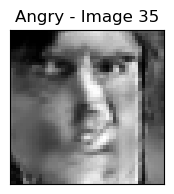

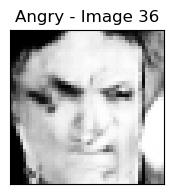

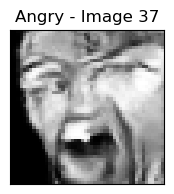

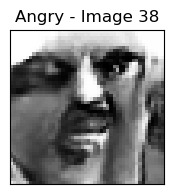

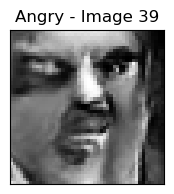

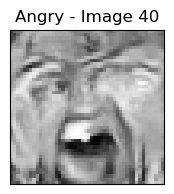

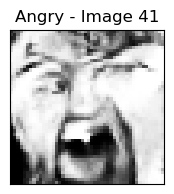

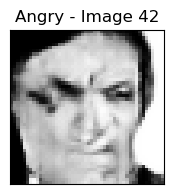

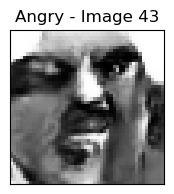

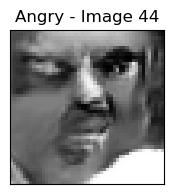

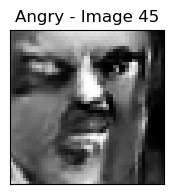

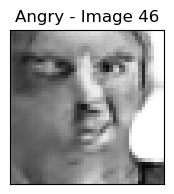

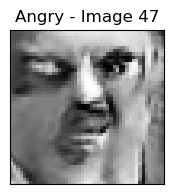

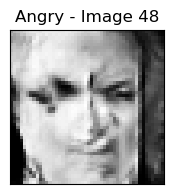

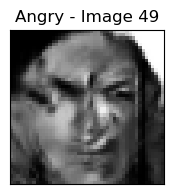

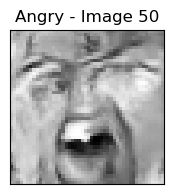

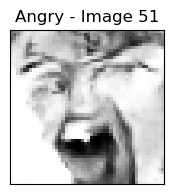

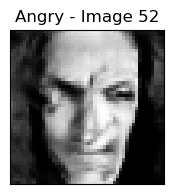

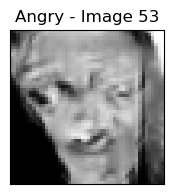

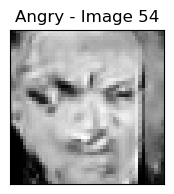

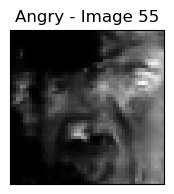

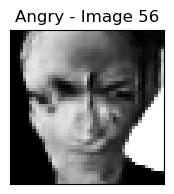

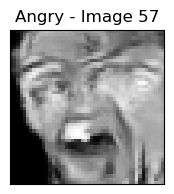

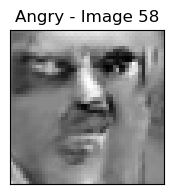

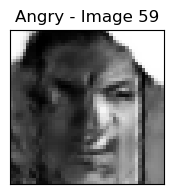

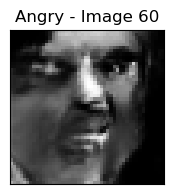

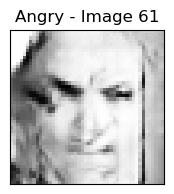

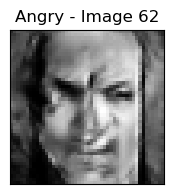

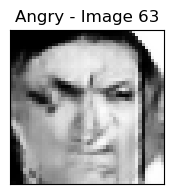

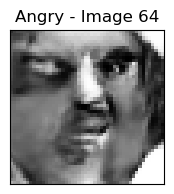

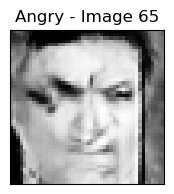

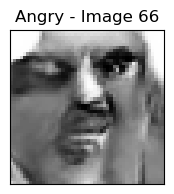

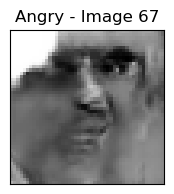

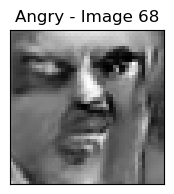

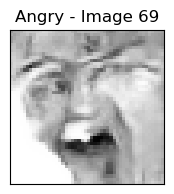

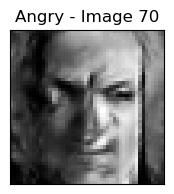

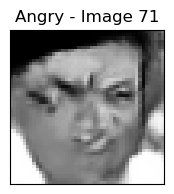

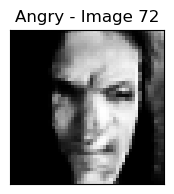

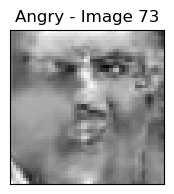

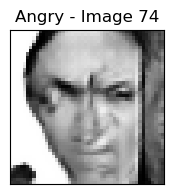

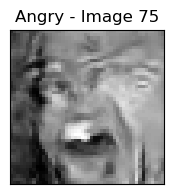

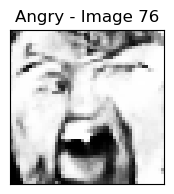

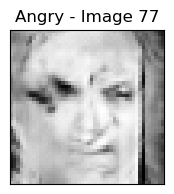

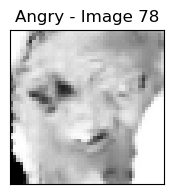

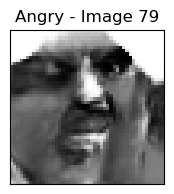

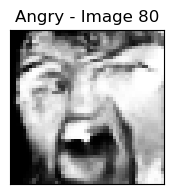

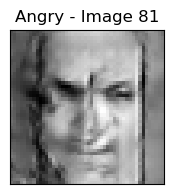

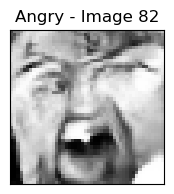

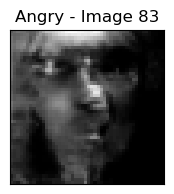

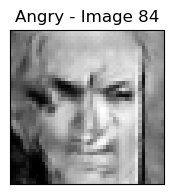

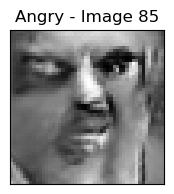

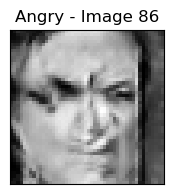

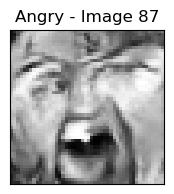

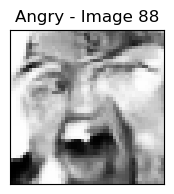

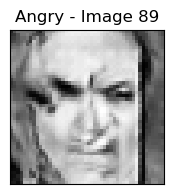

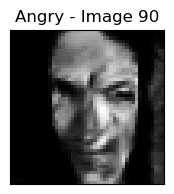

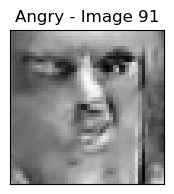

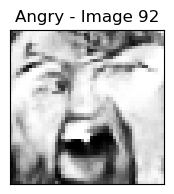

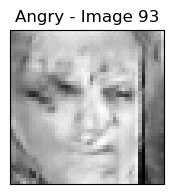

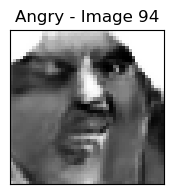

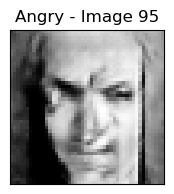

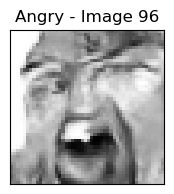

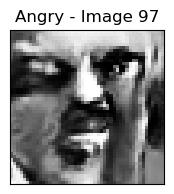

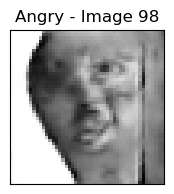

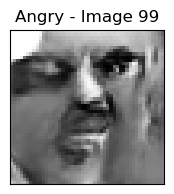

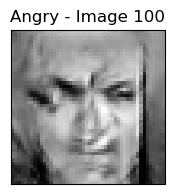

Displaying 100 images for emotion: Disgust


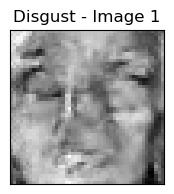

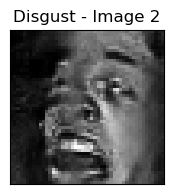

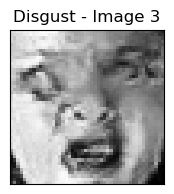

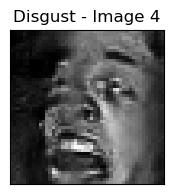

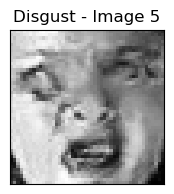

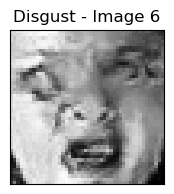

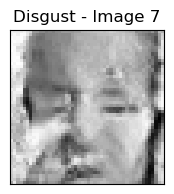

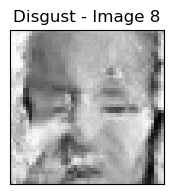

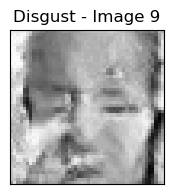

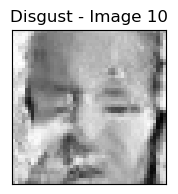

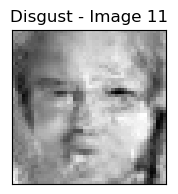

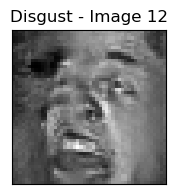

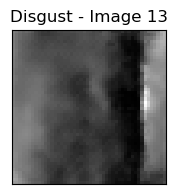

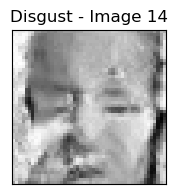

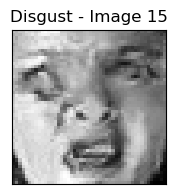

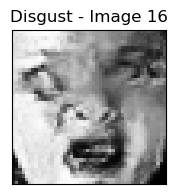

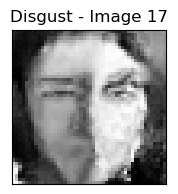

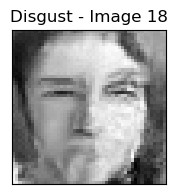

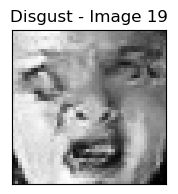

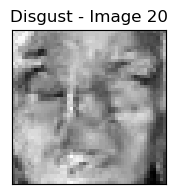

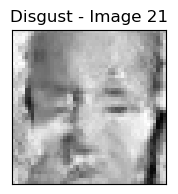

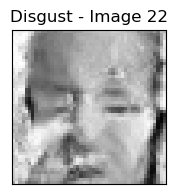

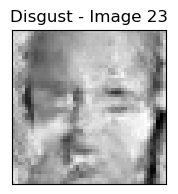

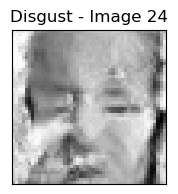

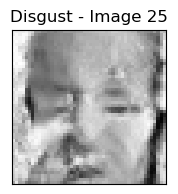

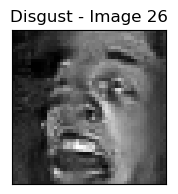

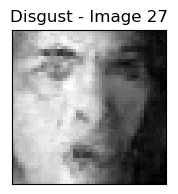

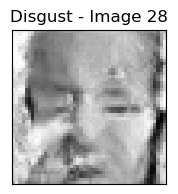

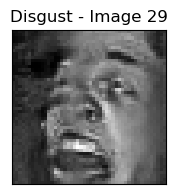

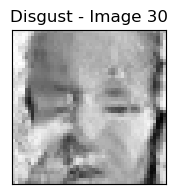

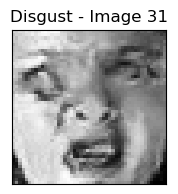

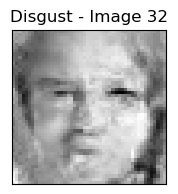

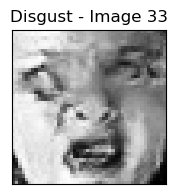

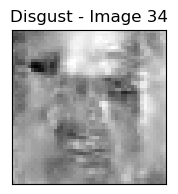

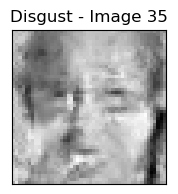

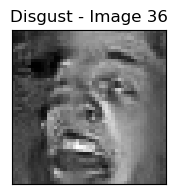

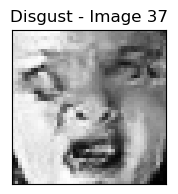

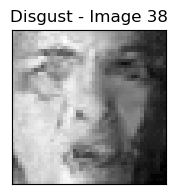

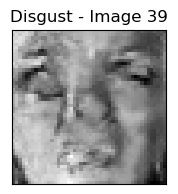

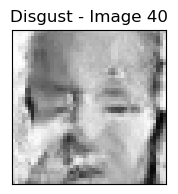

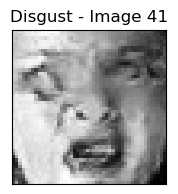

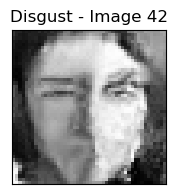

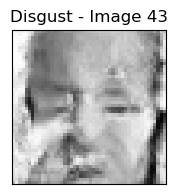

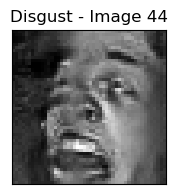

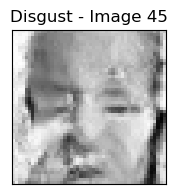

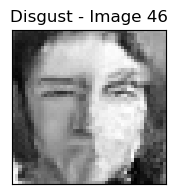

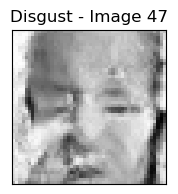

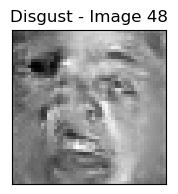

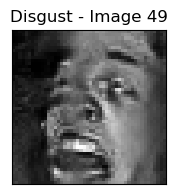

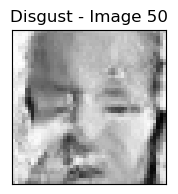

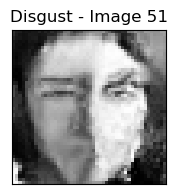

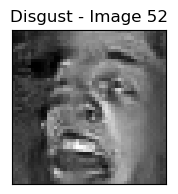

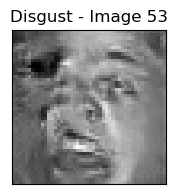

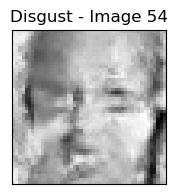

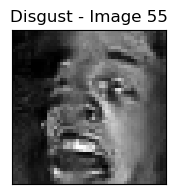

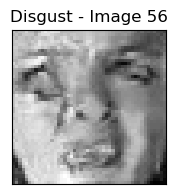

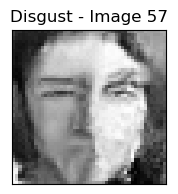

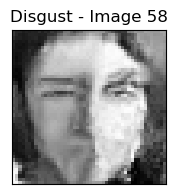

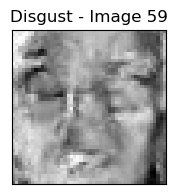

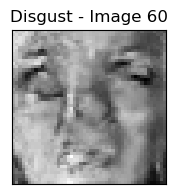

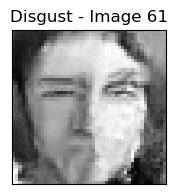

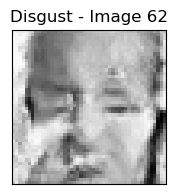

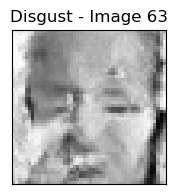

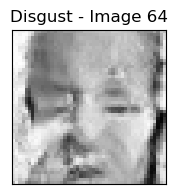

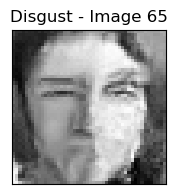

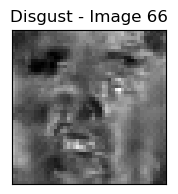

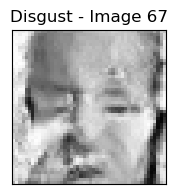

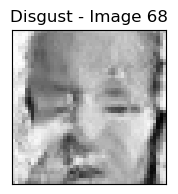

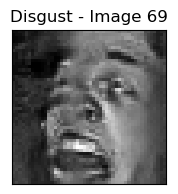

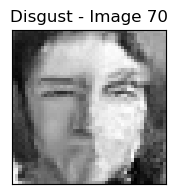

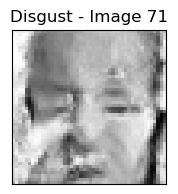

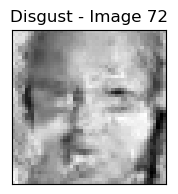

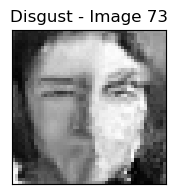

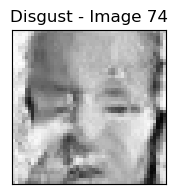

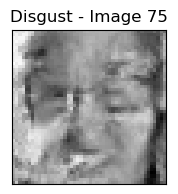

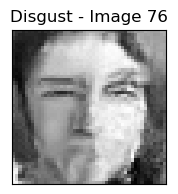

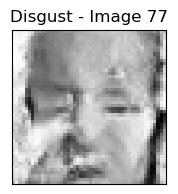

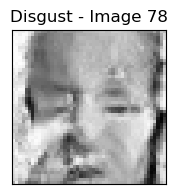

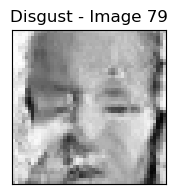

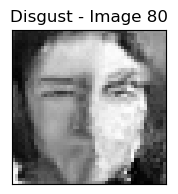

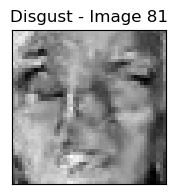

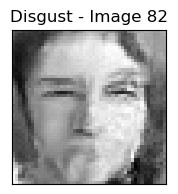

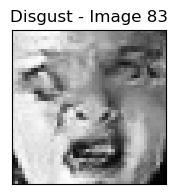

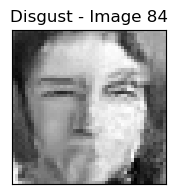

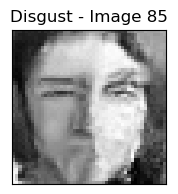

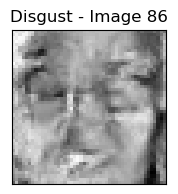

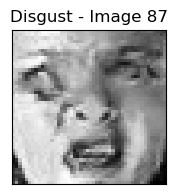

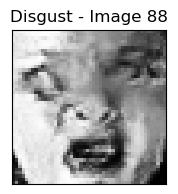

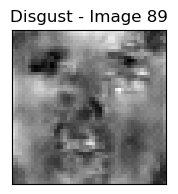

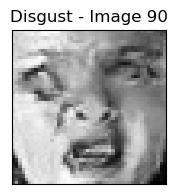

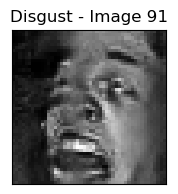

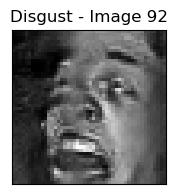

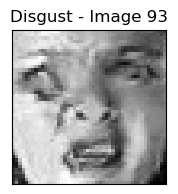

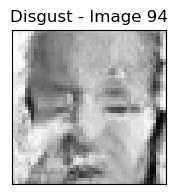

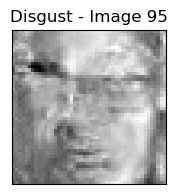

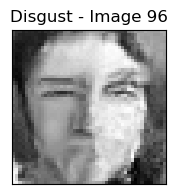

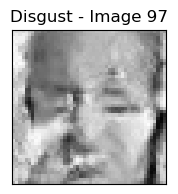

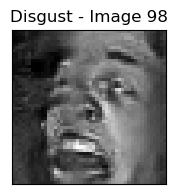

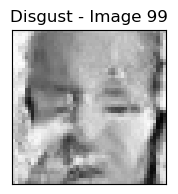

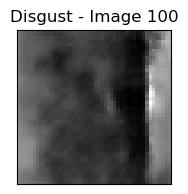

Displaying 100 images for emotion: Fear


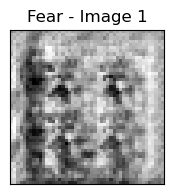

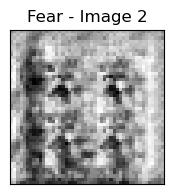

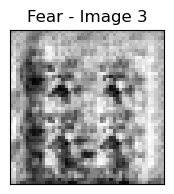

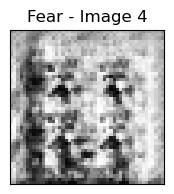

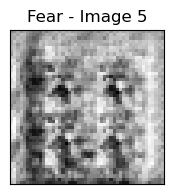

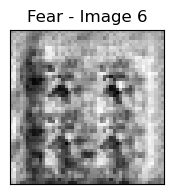

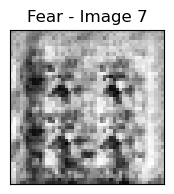

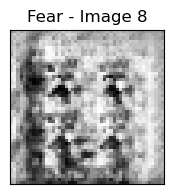

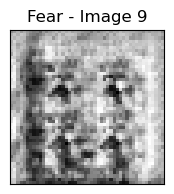

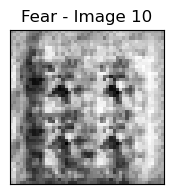

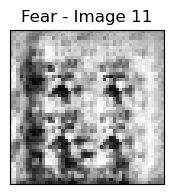

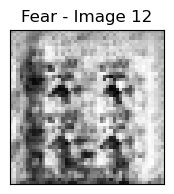

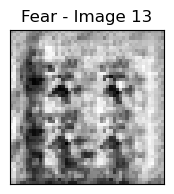

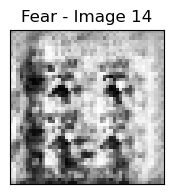

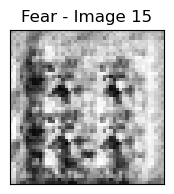

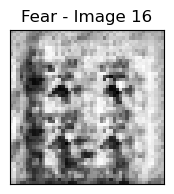

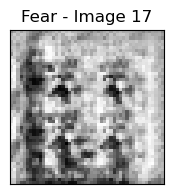

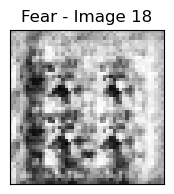

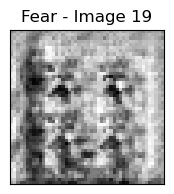

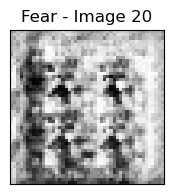

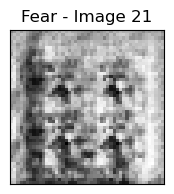

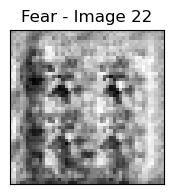

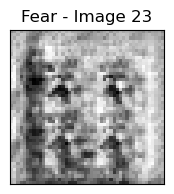

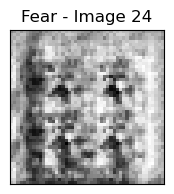

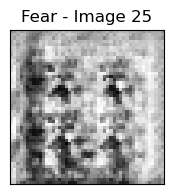

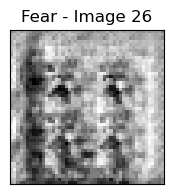

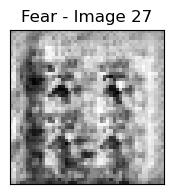

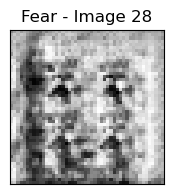

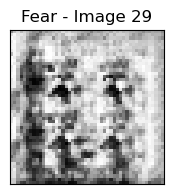

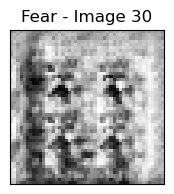

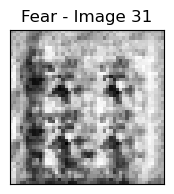

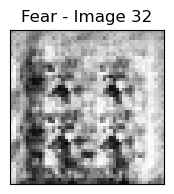

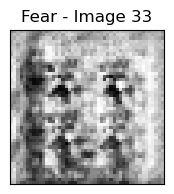

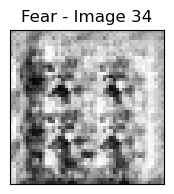

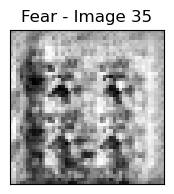

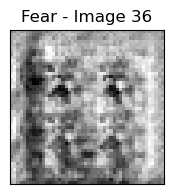

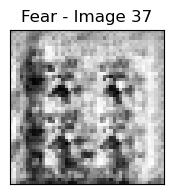

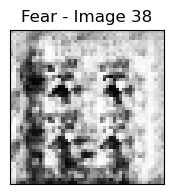

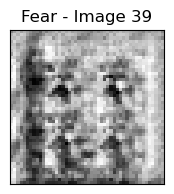

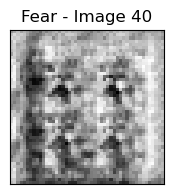

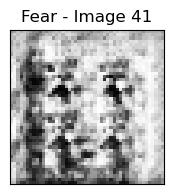

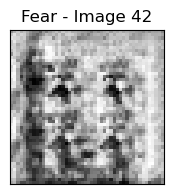

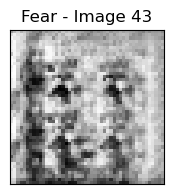

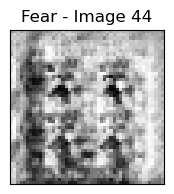

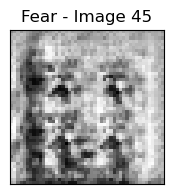

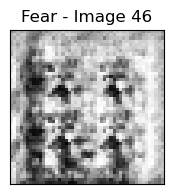

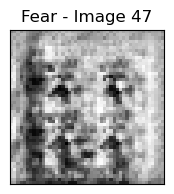

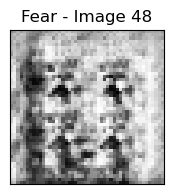

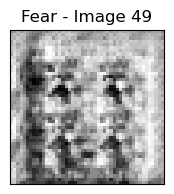

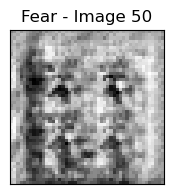

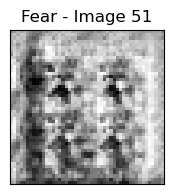

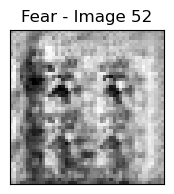

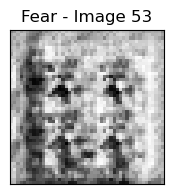

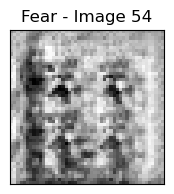

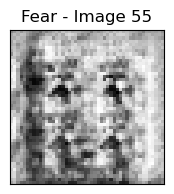

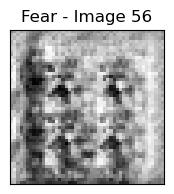

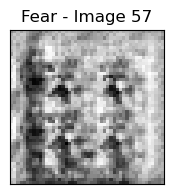

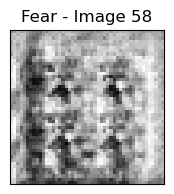

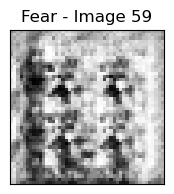

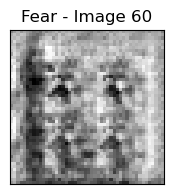

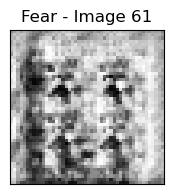

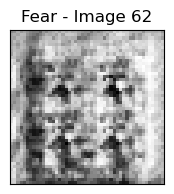

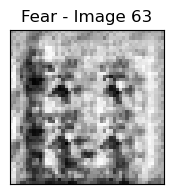

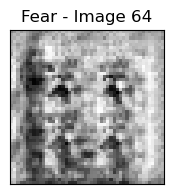

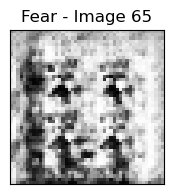

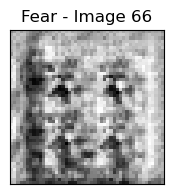

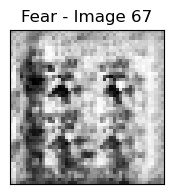

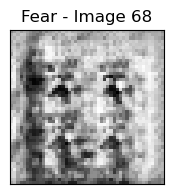

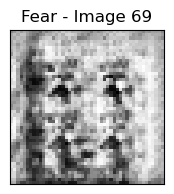

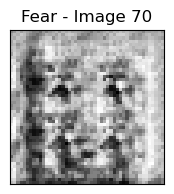

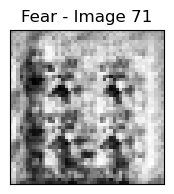

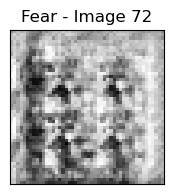

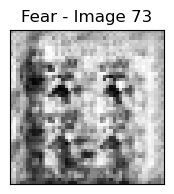

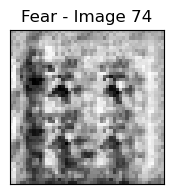

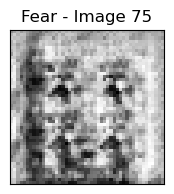

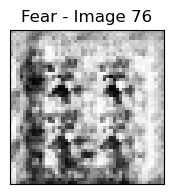

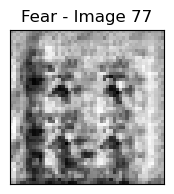

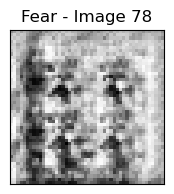

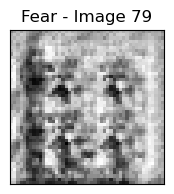

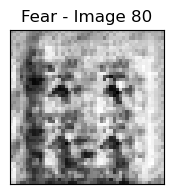

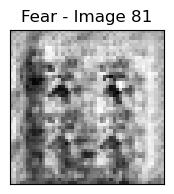

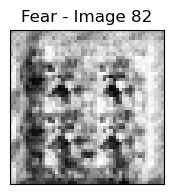

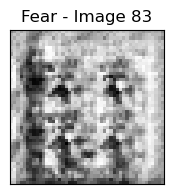

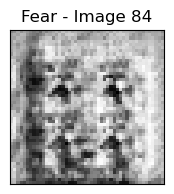

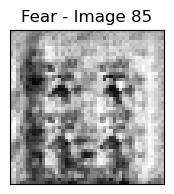

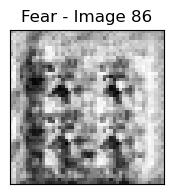

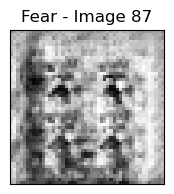

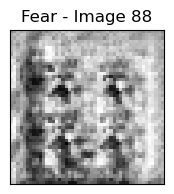

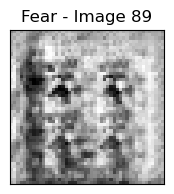

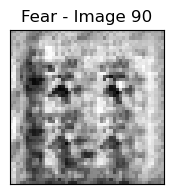

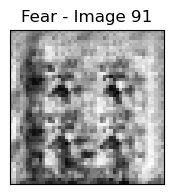

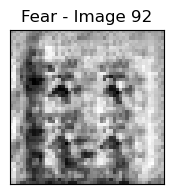

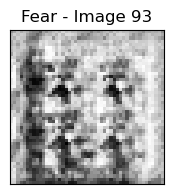

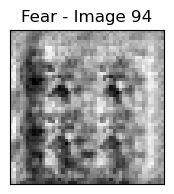

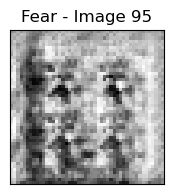

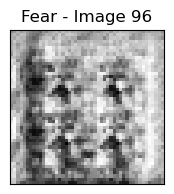

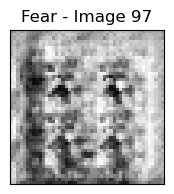

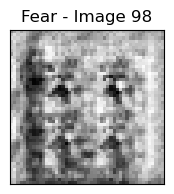

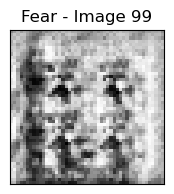

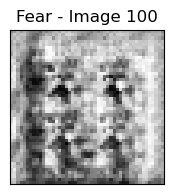

Displaying 100 images for emotion: Happy


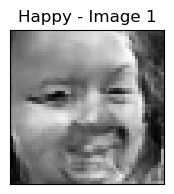

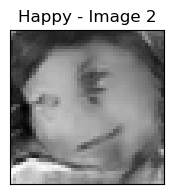

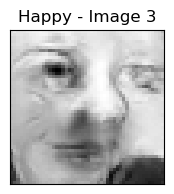

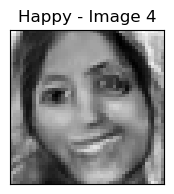

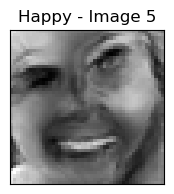

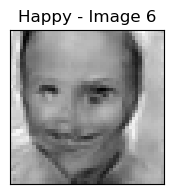

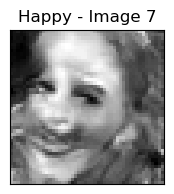

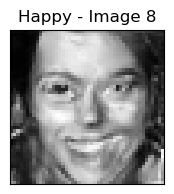

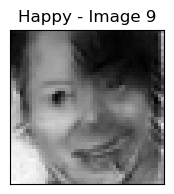

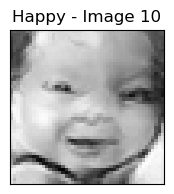

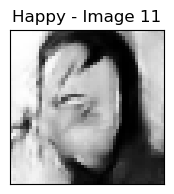

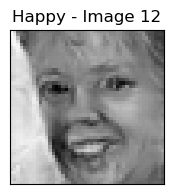

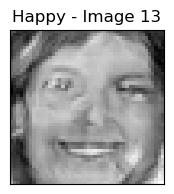

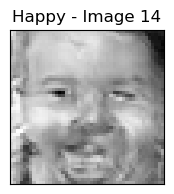

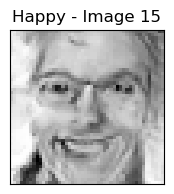

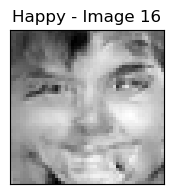

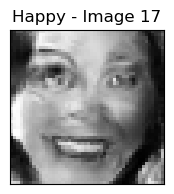

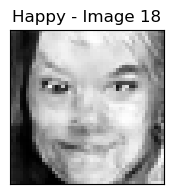

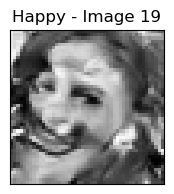

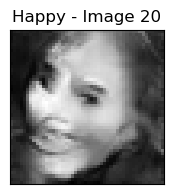

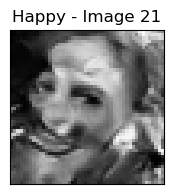

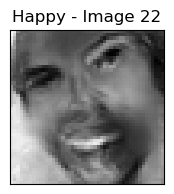

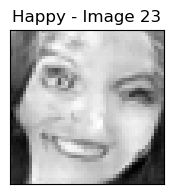

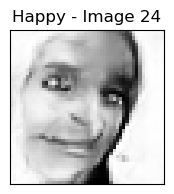

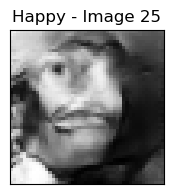

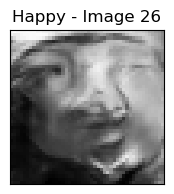

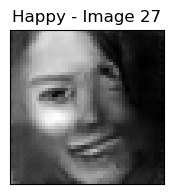

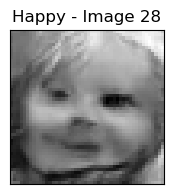

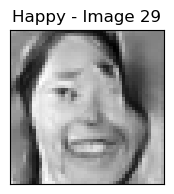

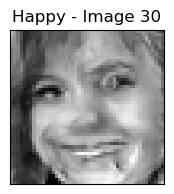

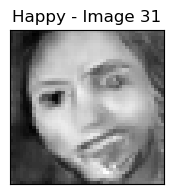

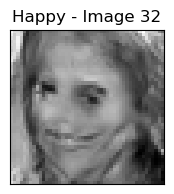

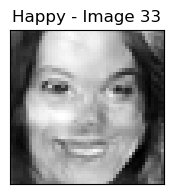

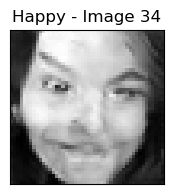

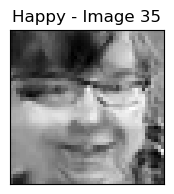

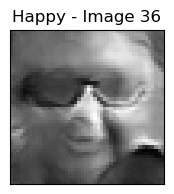

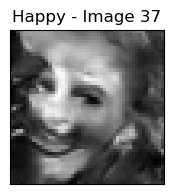

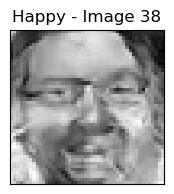

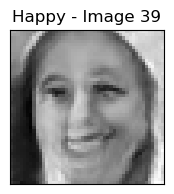

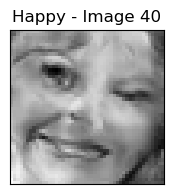

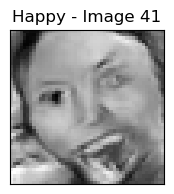

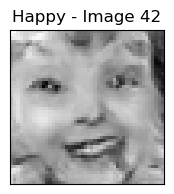

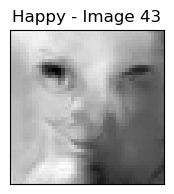

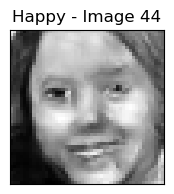

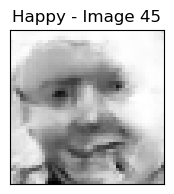

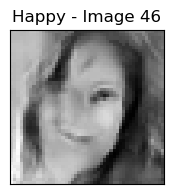

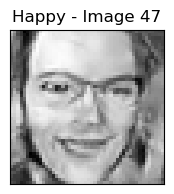

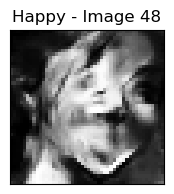

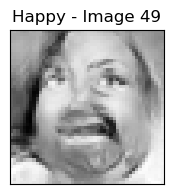

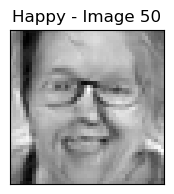

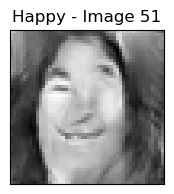

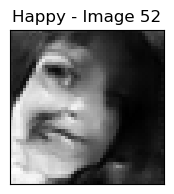

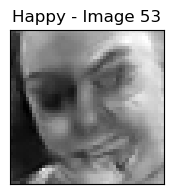

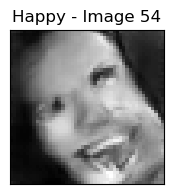

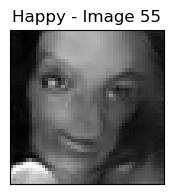

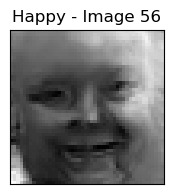

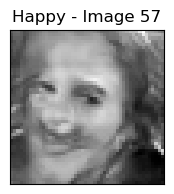

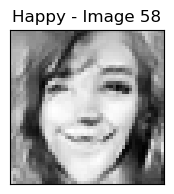

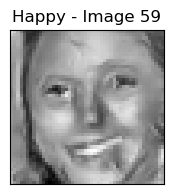

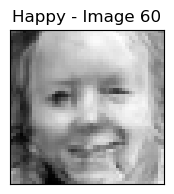

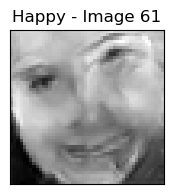

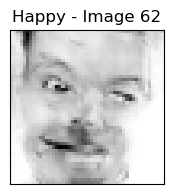

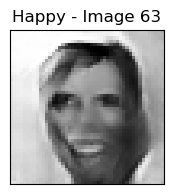

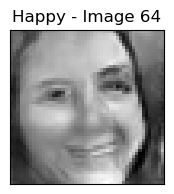

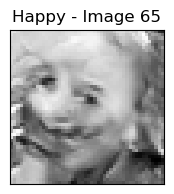

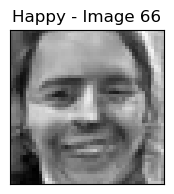

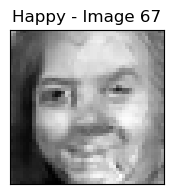

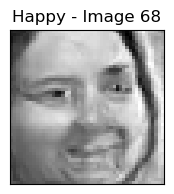

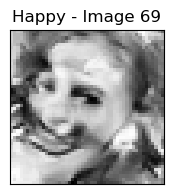

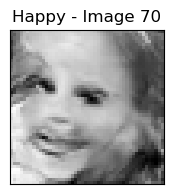

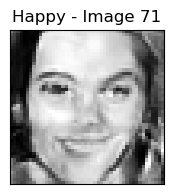

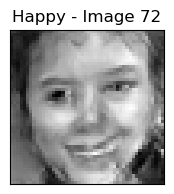

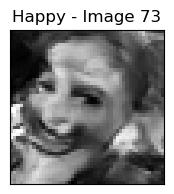

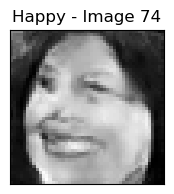

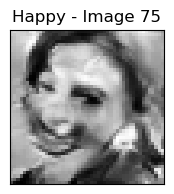

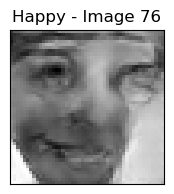

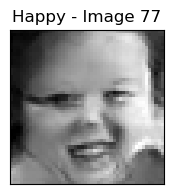

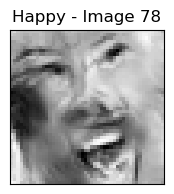

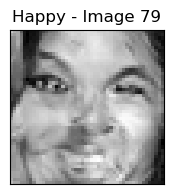

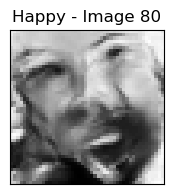

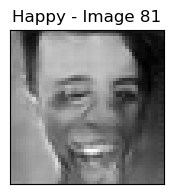

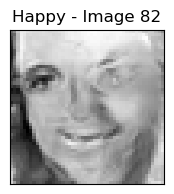

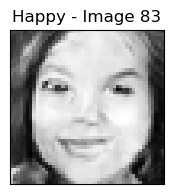

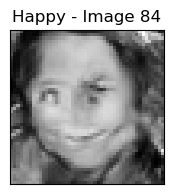

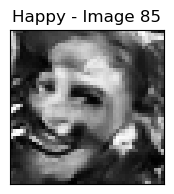

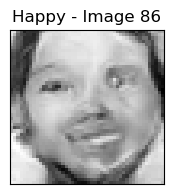

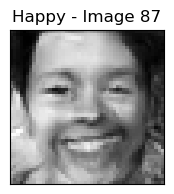

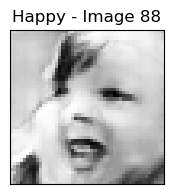

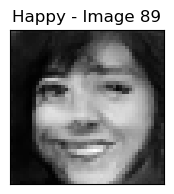

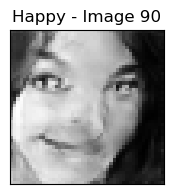

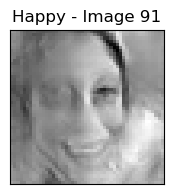

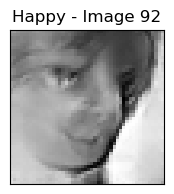

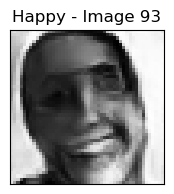

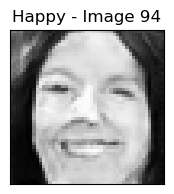

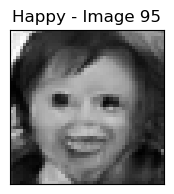

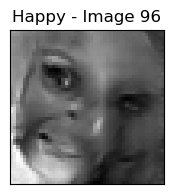

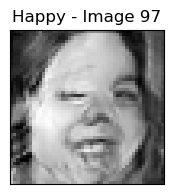

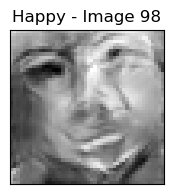

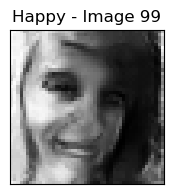

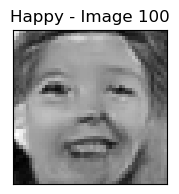

Displaying 100 images for emotion: Sad


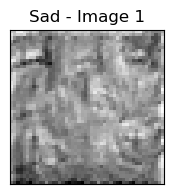

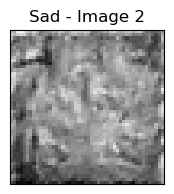

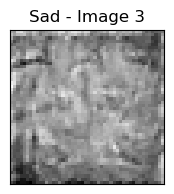

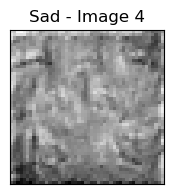

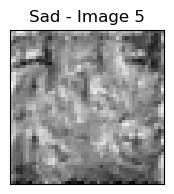

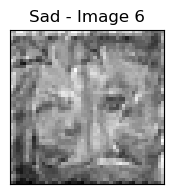

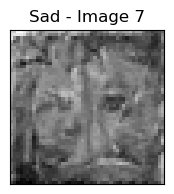

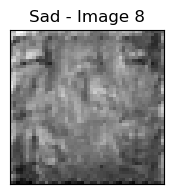

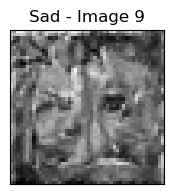

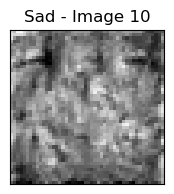

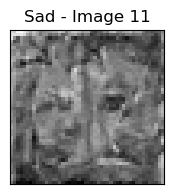

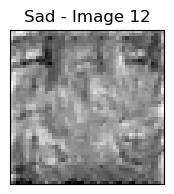

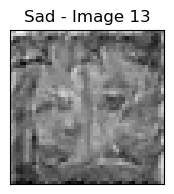

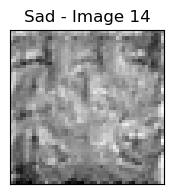

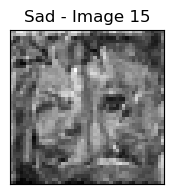

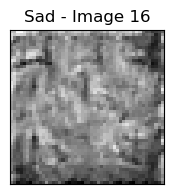

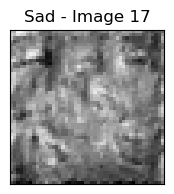

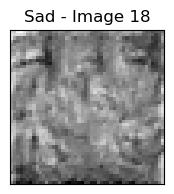

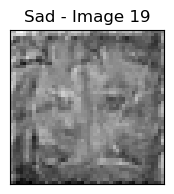

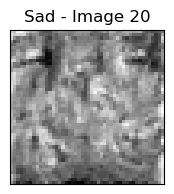

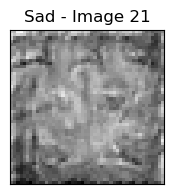

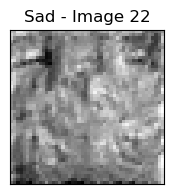

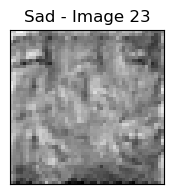

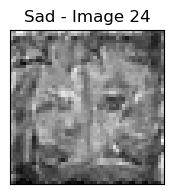

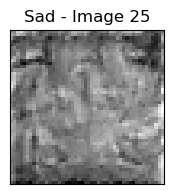

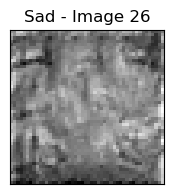

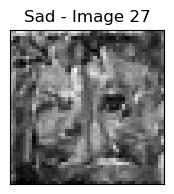

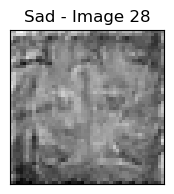

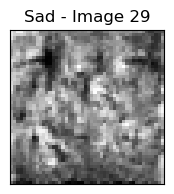

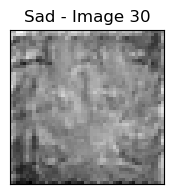

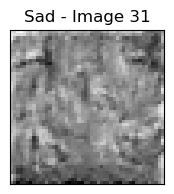

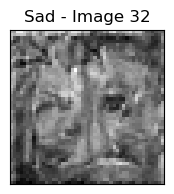

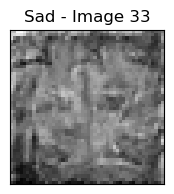

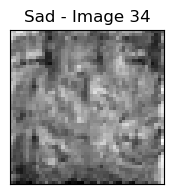

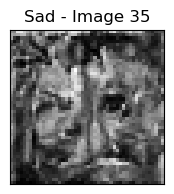

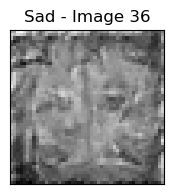

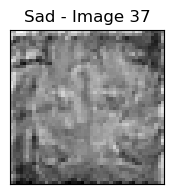

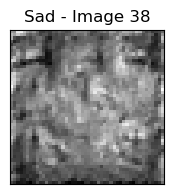

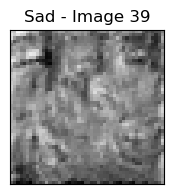

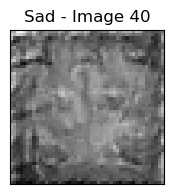

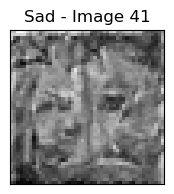

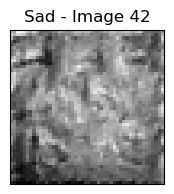

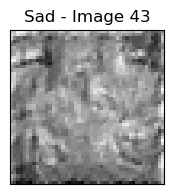

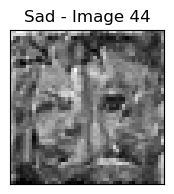

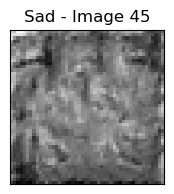

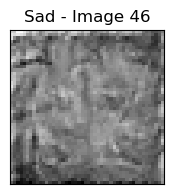

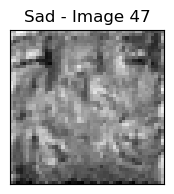

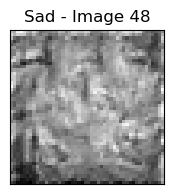

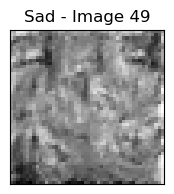

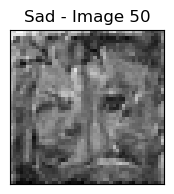

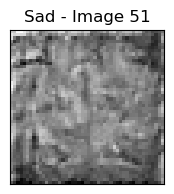

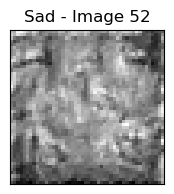

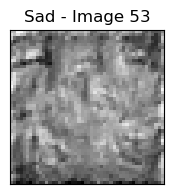

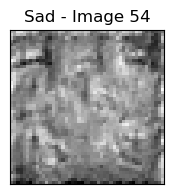

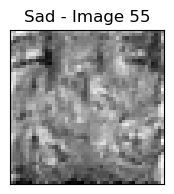

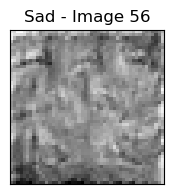

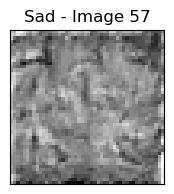

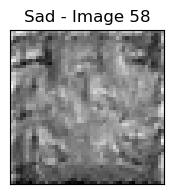

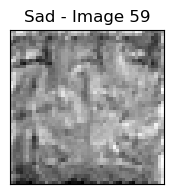

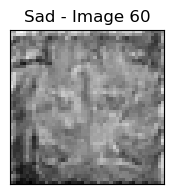

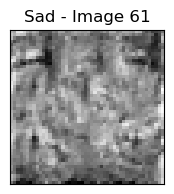

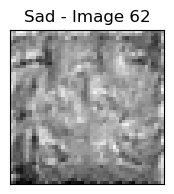

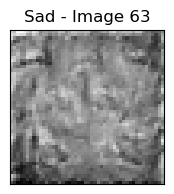

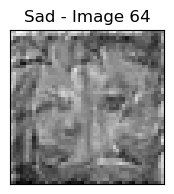

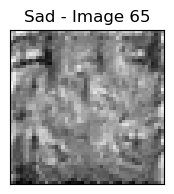

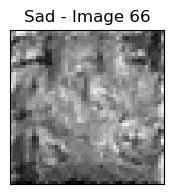

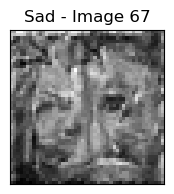

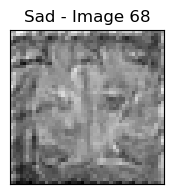

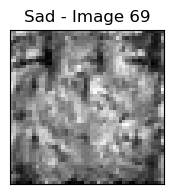

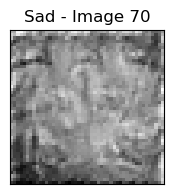

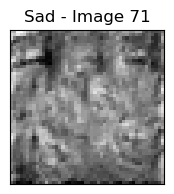

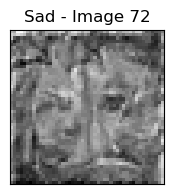

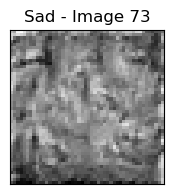

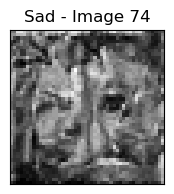

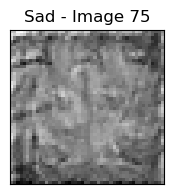

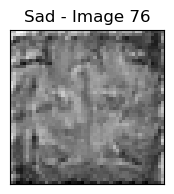

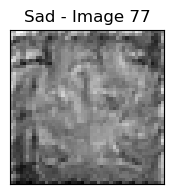

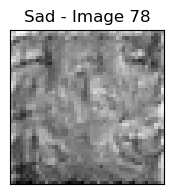

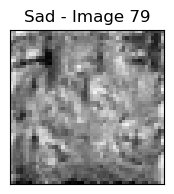

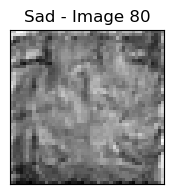

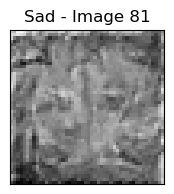

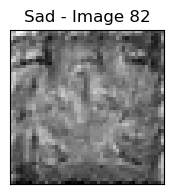

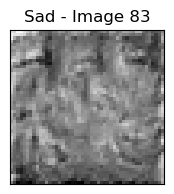

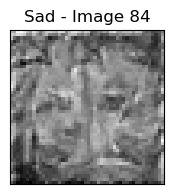

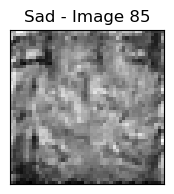

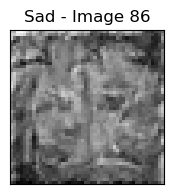

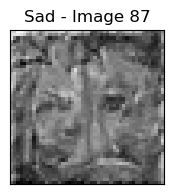

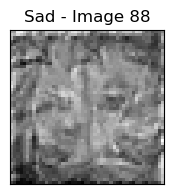

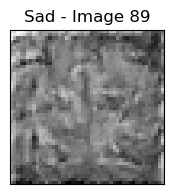

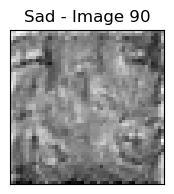

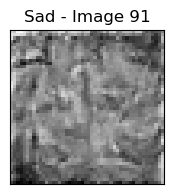

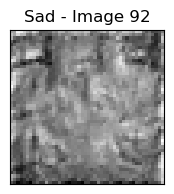

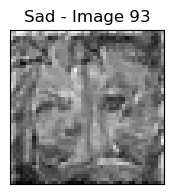

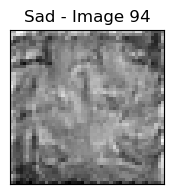

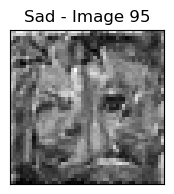

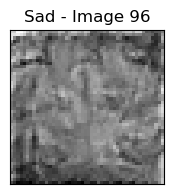

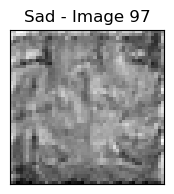

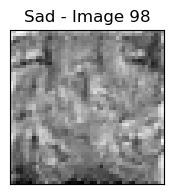

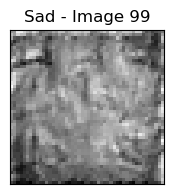

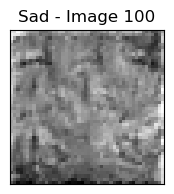

Displaying 100 images for emotion: Surprise


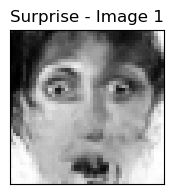

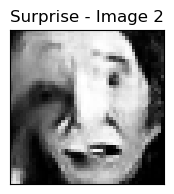

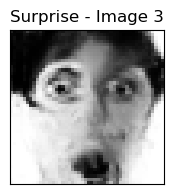

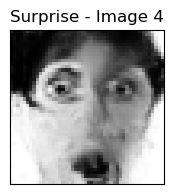

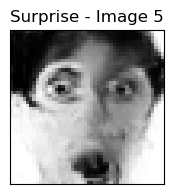

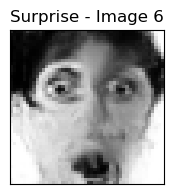

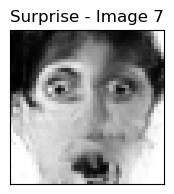

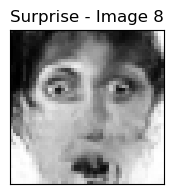

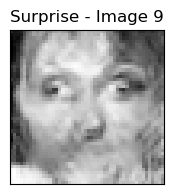

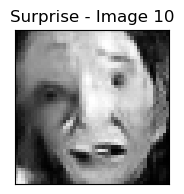

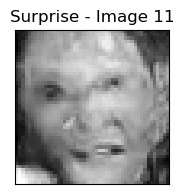

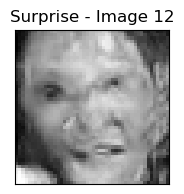

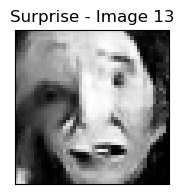

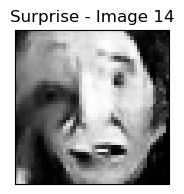

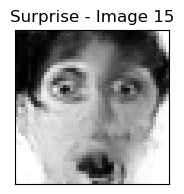

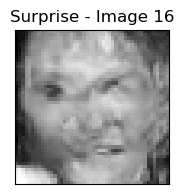

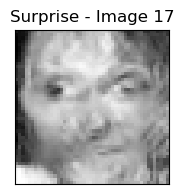

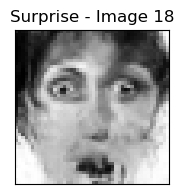

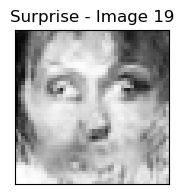

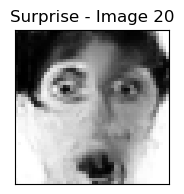

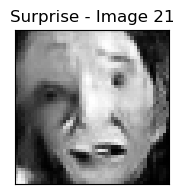

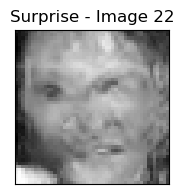

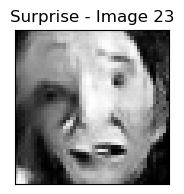

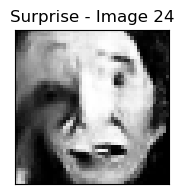

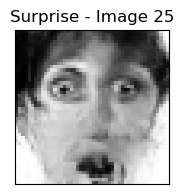

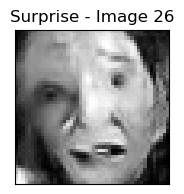

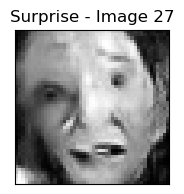

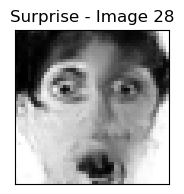

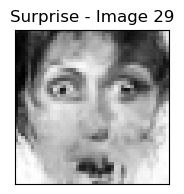

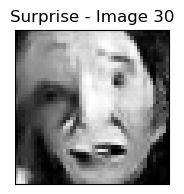

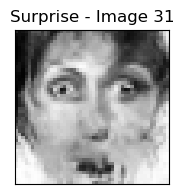

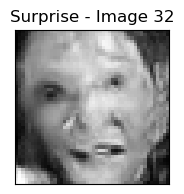

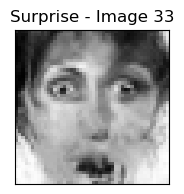

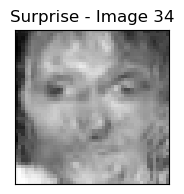

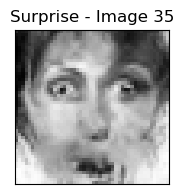

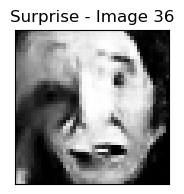

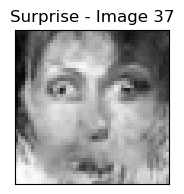

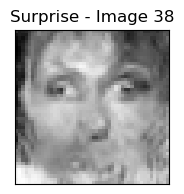

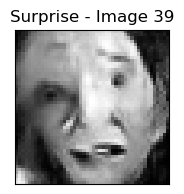

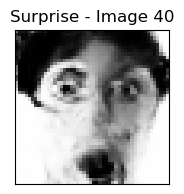

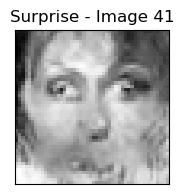

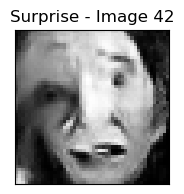

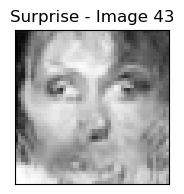

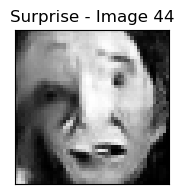

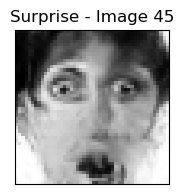

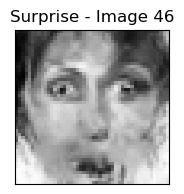

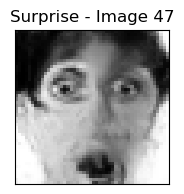

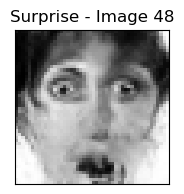

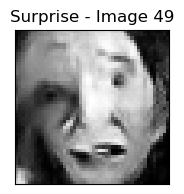

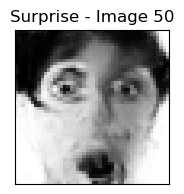

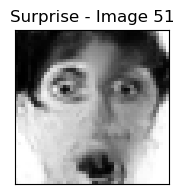

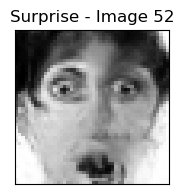

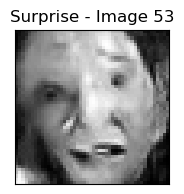

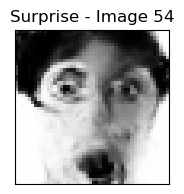

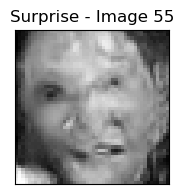

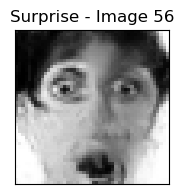

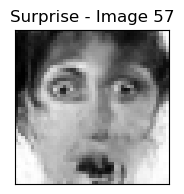

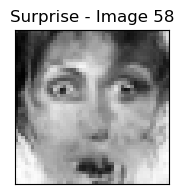

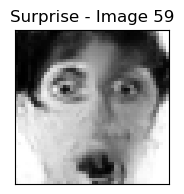

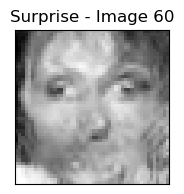

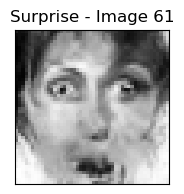

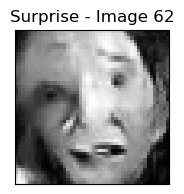

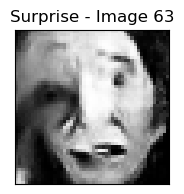

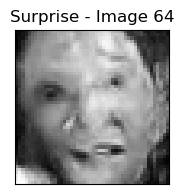

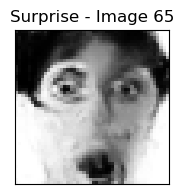

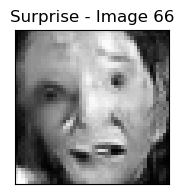

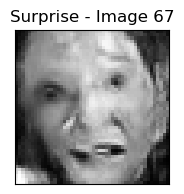

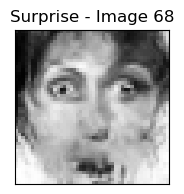

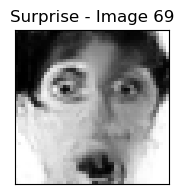

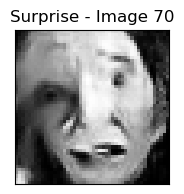

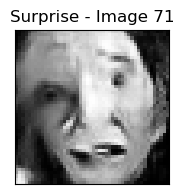

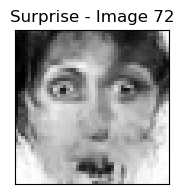

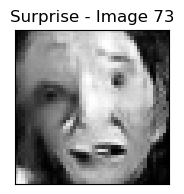

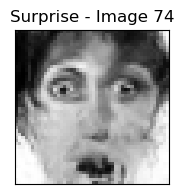

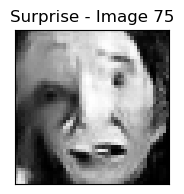

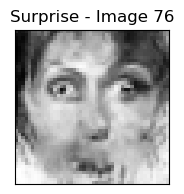

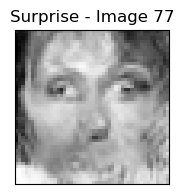

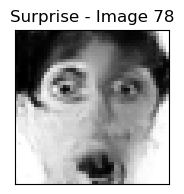

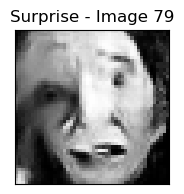

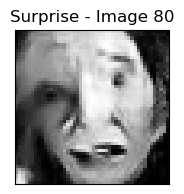

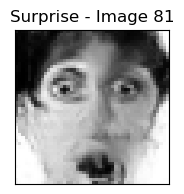

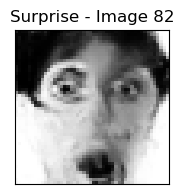

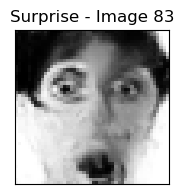

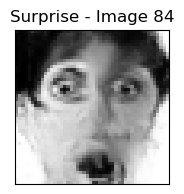

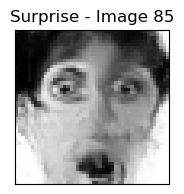

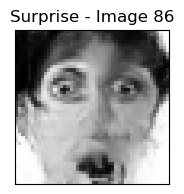

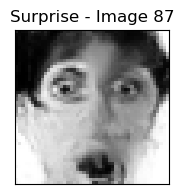

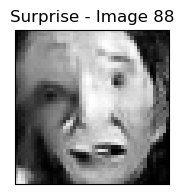

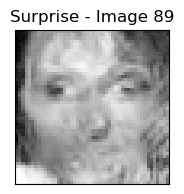

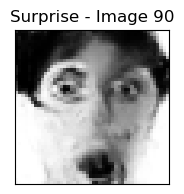

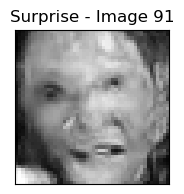

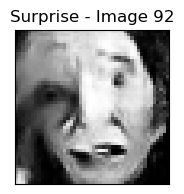

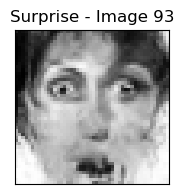

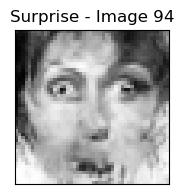

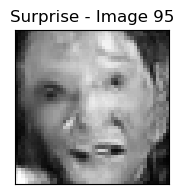

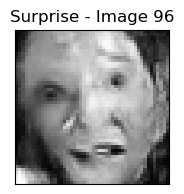

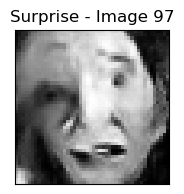

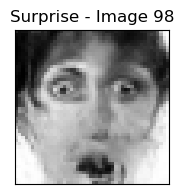

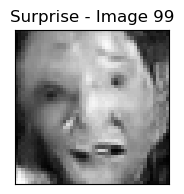

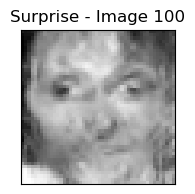

Displaying 100 images for emotion: Neutral


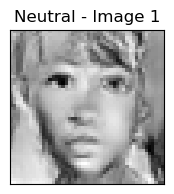

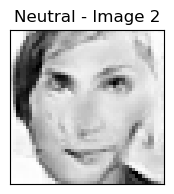

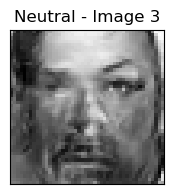

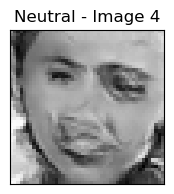

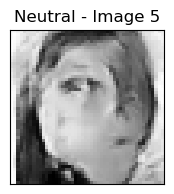

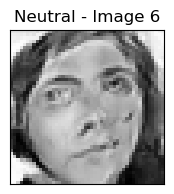

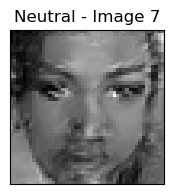

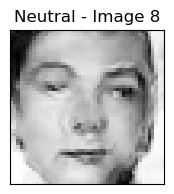

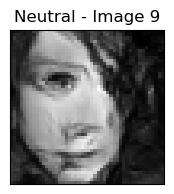

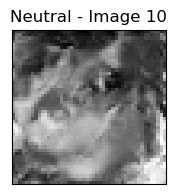

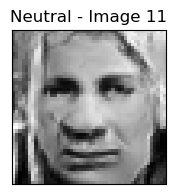

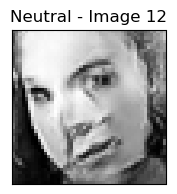

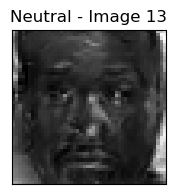

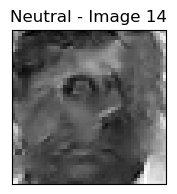

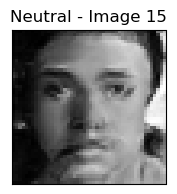

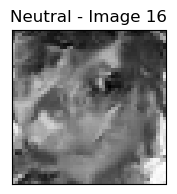

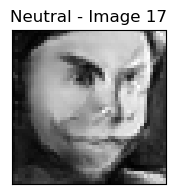

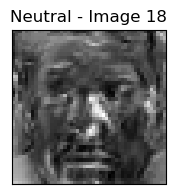

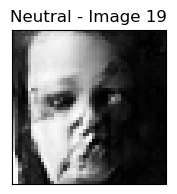

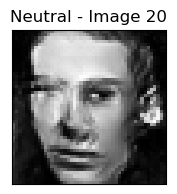

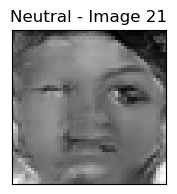

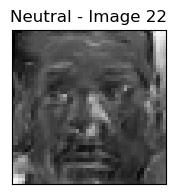

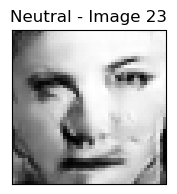

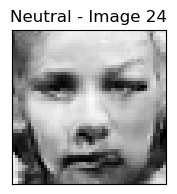

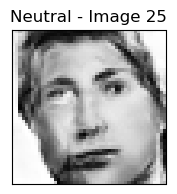

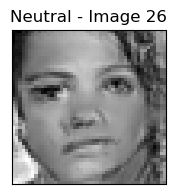

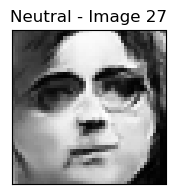

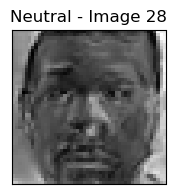

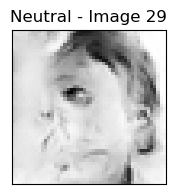

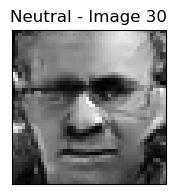

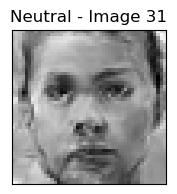

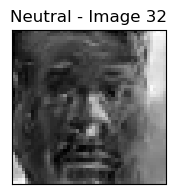

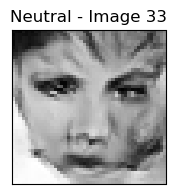

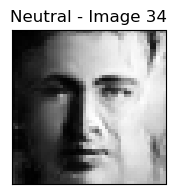

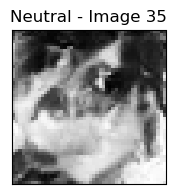

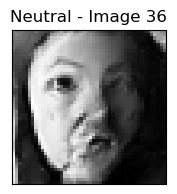

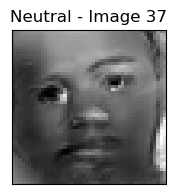

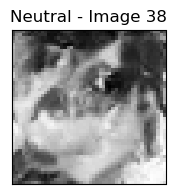

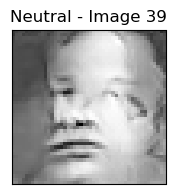

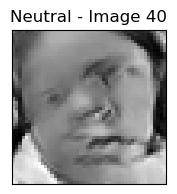

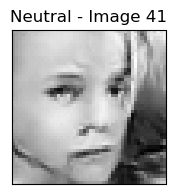

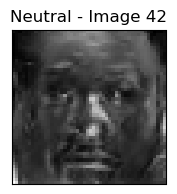

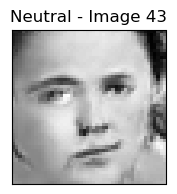

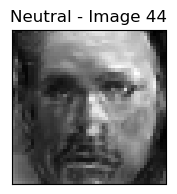

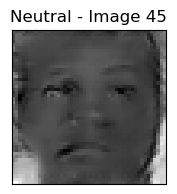

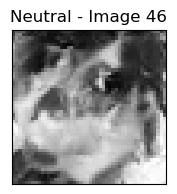

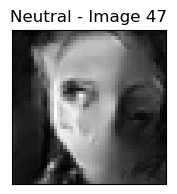

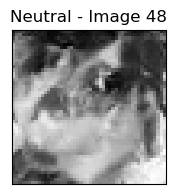

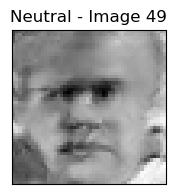

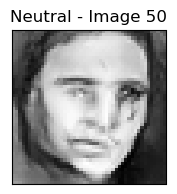

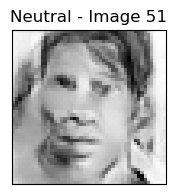

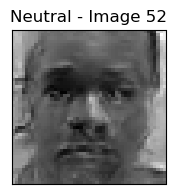

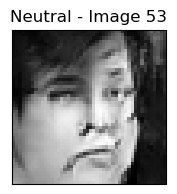

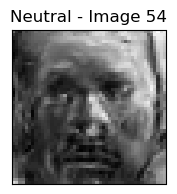

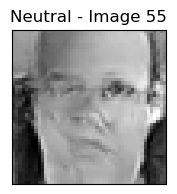

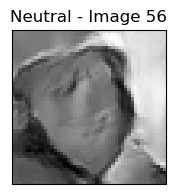

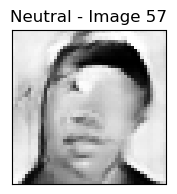

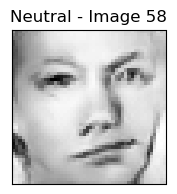

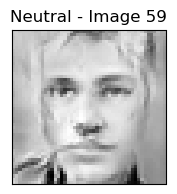

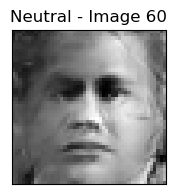

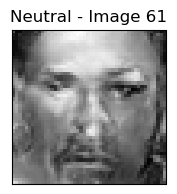

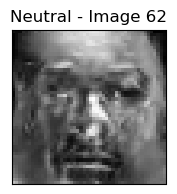

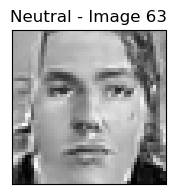

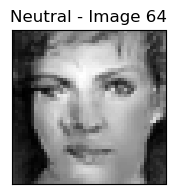

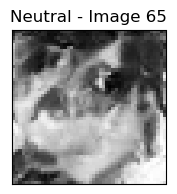

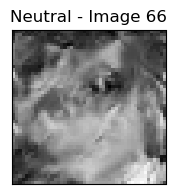

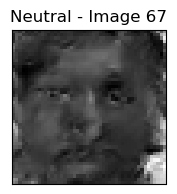

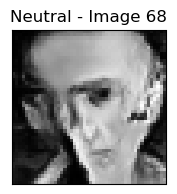

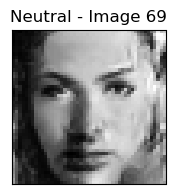

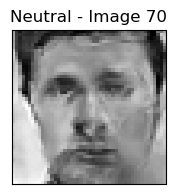

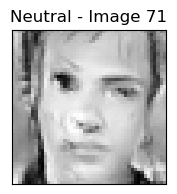

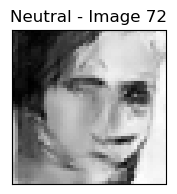

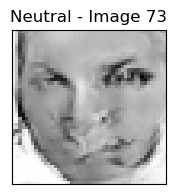

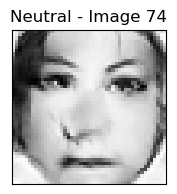

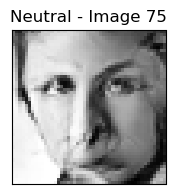

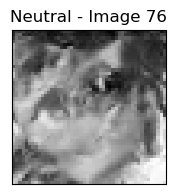

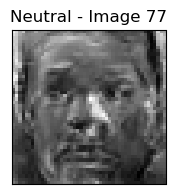

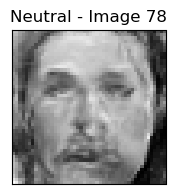

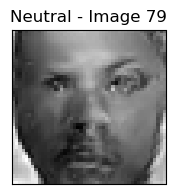

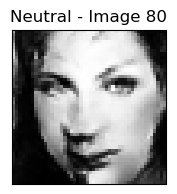

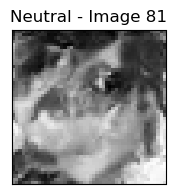

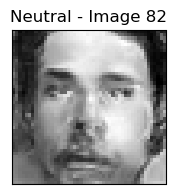

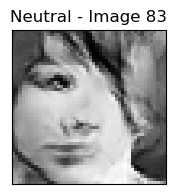

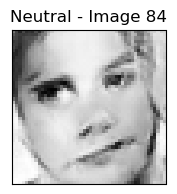

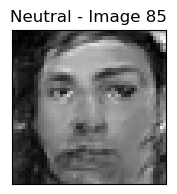

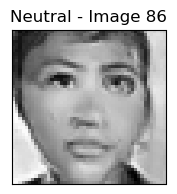

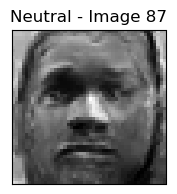

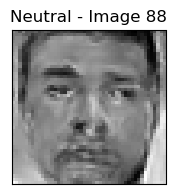

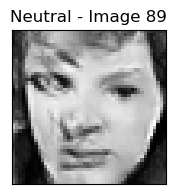

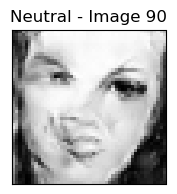

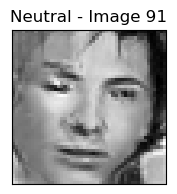

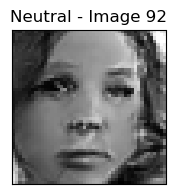

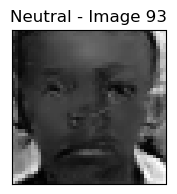

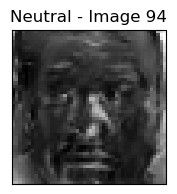

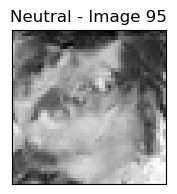

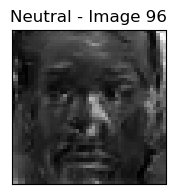

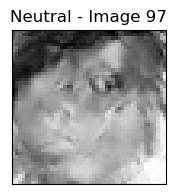

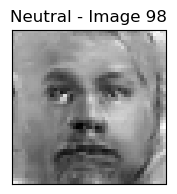

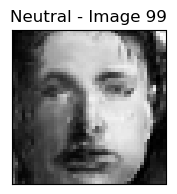

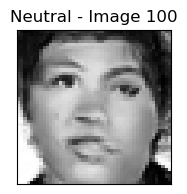

In [3]:
fig = plt.figure(1, (14, 14))
k = 0
emotion_labels = {0:'Angry', 1:'Disgust', 2:'Fear', 3:'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}
emotion_labels

for label in sorted(train_df.emotion.unique()):
    print(f"Displaying 100 images for emotion: {emotion_labels[label]}")
    # Filter rows corresponding to the current label
    images = train_df[train_df.emotion == label].pixels.iloc[:100]  # Select first 100 images for this emotion
    
    for idx, px in enumerate(images):
        # Convert pixels string to a numpy array and reshape
        px = np.array(px.split(' ')).reshape(48, 48).astype('float32')
        
        # Create a new figure for each image
        plt.figure(figsize=(2, 2))
        plt.imshow(px, cmap='gray')
        plt.xticks([])  # Remove x ticks
        plt.yticks([])  # Remove y ticks
        plt.title(f"{emotion_labels[label]} - Image {idx+1}")
        
        # Display the figure
        plt.show()

"Sad" and "Fear" appear to be largerly unusable. We omit these poor quality images from the dataset we will use to further train the model, as they may cause the model's performance to decrease.

In [3]:
# Sad and fear are unusable
filtered_train_df = train_df[(train_df['emotion'] != 2) & (train_df['emotion'] != 4)]


In [4]:
val_df = load_data("data/validation.csv")

print("Training Data")
print(train_df.head(10))

print("\n\nValidation Data")
print(val_df.head(10))

Training Data
   emotion                                             pixels
0        0  8 10 16 18 31 43 50 64 82 113 134 155 169 183 ...
1        0  24 50 88 154 237 249 250 248 247 249 249 247 2...
2        0  115 219 178 54 7 0 0 0 0 0 0 0 0 0 0 0 0 0 2 8...
3        0  0 1 4 3 6 6 9 10 9 9 14 18 17 16 19 30 58 91 1...
4        0  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...
5        0  0 0 0 0 0 0 0 0 0 0 0 0 0 1 12 42 67 107 131 1...
6        0  255 255 255 254 254 254 254 224 82 5 1 1 1 1 1...
7        0  254 254 254 254 254 254 254 254 254 251 201 84...
8        0  88 76 77 83 85 89 98 115 128 149 173 192 203 2...
9        0  67 95 126 141 155 166 166 167 170 180 194 197 ...


Validation Data
   emotion                                             pixels
0        3  254 253 253 254 254 254 252 252 253 252 253 25...
1        4  92 70 64 65 62 64 91 139 167 181 186 187 191 1...
2        5  20 19 16 23 24 25 34 24 25 60 113 123 139 149 ...
3        4  79 82 83 84 85 89 92 90 93

In [5]:
print("Training data shape:", filtered_train_df.shape)
print("Validation data shape", val_df.shape)

Training data shape: (10000, 2)
Validation data shape (5742, 2)


## 2. Create datasets with GAN images

In [6]:
# Define a default transformation pipeline
transform = transforms.Compose([
    ReshapeAndScale(n_rows=48, n_cols=48),
    transforms.Normalize(mean=[0.5], std=[0.5])  # Normalize to [-1, 1]
])

In [7]:
train_dataset = Fer2013Dataset(filtered_train_df, filtered_train_df['emotion'], transform=transform)
val_dataset = Fer2013Dataset(val_df, val_df['emotion'], transform=transform)

### Create DataLoaders

We create DataLoaders for both subsets to enable batch processing. The training DataLoader shuffles the data for better learning, while the validation DataLoader does not. Finally, we print the shapes of the batches to verify that everything works correctly.


In [8]:
batch_size = 32
train_loader, val_loader = create_dataloaders(train_dataset, val_dataset, batch_size)

## 3. Load the trained baseline model

Below, we define our CNN model class to match the baseline model in notebook one, i.e. the model we define as our baseline for our experiments.

In the `forward` method of the `CNN` class, the `torch.no_grad()` context is used to prevent the tracking of gradients during the forward pass. This is crucial when we are performing **transfer learning** because:

-  **Avoid Overfitting**: Fine-tuning with a small dataset of faces (such as GAN-generated faces) can lead to overfitting if we adjust the convolutional weights too much. Freezing these layers by using torch.no_grad() helps preserve the robust features learned from a large dataset (such as ImageNet or other large-scale datasets) and prevents overfitting to the smaller dataset of faces.
  
- **Preserving Facial Feature Learning**: The convolutional layers in the pre-trained model may have learned complex hierarchical patterns that are well-suited for recognizing faces (such as edges, textures, and shapes). By freezing these layers, we preserve this valuable feature extraction process and only fine-tune the final decision-making layers (fully connected layers) to classify or predict emotions from face images.




In [10]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        # 1st Conv Layer
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding='valid')
        self.bn1 = nn.BatchNorm2d(32)
        self.dropout1 = nn.Dropout(0.25)

        # 2nd Conv Layer
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding='same')
        self.bn2 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        # 3rd Conv Layer
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding='valid')
        self.bn3 = nn.BatchNorm2d(64)
        self.dropout3 = nn.Dropout(0.25)

        # 4th Conv Layer
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding='same')
        self.bn4 = nn.BatchNorm2d(128)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        # 5th Conv Layer
        self.conv5 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding='valid')
        self.bn5 = nn.BatchNorm2d(128)
        self.pool5 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Calculate the flatten size dynamically
        self.flatten_size = self._get_flatten_size()

        # Fully Connected Layers
        self.fc1 = nn.Linear(self.flatten_size, 250)
        self.dropout_fc = nn.Dropout(0.5)
        self.fc2 = nn.Linear(250, 7)  # 7 classes for emotion recognition

    def _get_flatten_size(self):
        # Create a dummy tensor with the same size as input image
        dummy_input = torch.zeros(1, 1, 48, 48)  # batch_size, channels, height, width
        dummy_output = self._forward_conv_layers(dummy_input)
        return dummy_output.numel()

    def _forward_conv_layers(self, x):
        # Pass through convolutional layers
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.dropout1(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.pool2(x)

        x = self.conv3(x)
        x = self.bn3(x)
        x = F.relu(x)
        x = self.dropout3(x)

        x = self.conv4(x)
        x = self.bn4(x)
        x = F.relu(x)
        x = self.pool4(x)

        x = self.conv5(x)
        x = self.bn5(x)
        x = F.relu(x)
        x = self.pool5(x)

        return x

    def forward(self, x):
        with torch.no_grad():
        # Do not update the convolutional layers, only the final layer for transfer learning
            x = self._forward_conv_layers(x)

        # Dynamically flatten the output

        x = x.view(x.size(0), -1)  # Flatten the tensor
        x = F.relu(self.fc1(x))
        x = self.dropout_fc(x)
        x = self.fc2(x)

        return x

# Instantiate the model
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(device)
model = CNN()

# Load the trained model
model_path = 'models/1_Group17_DLProject.pth'
model.load_state_dict(torch.load(model_path, weights_only=True))
model = model.to(device)

# Print the model structure
print(model)

mps
CNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=valid)
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout1): Dropout(p=0.25, inplace=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=valid)
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout3): Dropout(p=0.25, inplace=False)
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (bn4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv5): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding

In [11]:
criterion = nn.CrossEntropyLoss()  # Loss function for classification
optimizer = optim.Adam(model.parameters(), lr=0.0001)  # call optimizer

## 4. Train the Model

In this cell, we define the training loop for the trained CNN model:
- **Number of Epochs**: The model is fine-tuned for 35 epochs.
- **Training Process**:
  - The model is set to training mode.
  - For each batch, we move inputs and labels to the appropriate device, clear the gradients, perform forward and backward passes, and update the model's parameters using the optimizer.
  - The running loss is tracked and printed every 100 batches for monitoring.

In [12]:
# Initialize TensorBoard writer
writer = SummaryWriter(log_dir='tensorboard-runs/6_Group17_DLProject')

checkpoint_path = 'model-checkpoints/6_Group17_DLProject'
os.makedirs(checkpoint_path, exist_ok=True)
model_save_path = 'models'
os.makedirs(model_save_path, exist_ok=True)


num_epochs = 35
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for i, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if (i + 1) % 100 == 0:  # Print every 100 batches
            avg_loss = running_loss / 100
            print(f"Epoch [{epoch + 1}/{num_epochs}], Step [{i + 1}/{len(train_loader)}], Loss: {avg_loss:.4f}")
            running_loss = 0.0

            # Log loss to TensorBoard
            writer.add_scalar('Loss/train', avg_loss, epoch)

    # Save checkpoint every 10 epochs
    if (epoch + 1) % 10 == 0:
        checkpoint = {
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': running_loss,
        }
        torch.save(checkpoint, f"{checkpoint_path}/checkpoint_epoch_{epoch + 1}.pth")
        print(f"Checkpoint saved at epoch {epoch + 1}")

Epoch [1/35], Step [100/313], Loss: 0.4420
Epoch [1/35], Step [200/313], Loss: 0.1239
Epoch [1/35], Step [300/313], Loss: 0.0923
Epoch [2/35], Step [100/313], Loss: 0.0810
Epoch [2/35], Step [200/313], Loss: 0.0502
Epoch [2/35], Step [300/313], Loss: 0.0434
Epoch [3/35], Step [100/313], Loss: 0.0386
Epoch [3/35], Step [200/313], Loss: 0.0265
Epoch [3/35], Step [300/313], Loss: 0.0239
Epoch [4/35], Step [100/313], Loss: 0.0184
Epoch [4/35], Step [200/313], Loss: 0.0241
Epoch [4/35], Step [300/313], Loss: 0.0192
Epoch [5/35], Step [100/313], Loss: 0.0160
Epoch [5/35], Step [200/313], Loss: 0.0155
Epoch [5/35], Step [300/313], Loss: 0.0114
Epoch [6/35], Step [100/313], Loss: 0.0152
Epoch [6/35], Step [200/313], Loss: 0.0100
Epoch [6/35], Step [300/313], Loss: 0.0088
Epoch [7/35], Step [100/313], Loss: 0.0075
Epoch [7/35], Step [200/313], Loss: 0.0057
Epoch [7/35], Step [300/313], Loss: 0.0079
Epoch [8/35], Step [100/313], Loss: 0.0076
Epoch [8/35], Step [200/313], Loss: 0.0071
Epoch [8/35

KeyboardInterrupt: 

In [13]:
# Save the final model after training
final_model_path = os.path.join(model_save_path, '6_Group17_DLProject.pth')
torch.save(model.state_dict(), final_model_path)
print(f"Final model saved at {final_model_path}")
# Close the writer after training
writer.close()

Final model saved at models/6_Group17_DLProject.pth


## 5. Evaluate the Model

In this cell, we evaluate the trained model using the validation dataset:
- The model is set to evaluation mode, and gradient computation is disabled.
- For each batch, we perform a forward pass and predict the class labels.
- Labels and predictions are stored and used to generate a classification report using `sklearn`. This report provides precision, recall, and F1-scores for each emotion class.

              precision    recall  f1-score   support

       Angry       0.60      0.17      0.26       799
     Disgust       0.27      0.69      0.38        87
        Fear       1.00      0.02      0.04       820
       Happy       0.55      0.91      0.69      1443
         Sad       1.00      0.01      0.01       966
    Surprise       0.73      0.55      0.62       634
     Neutral       0.32      0.78      0.45       993

    accuracy                           0.46      5742
   macro avg       0.64      0.44      0.35      5742
weighted avg       0.67      0.46      0.37      5742



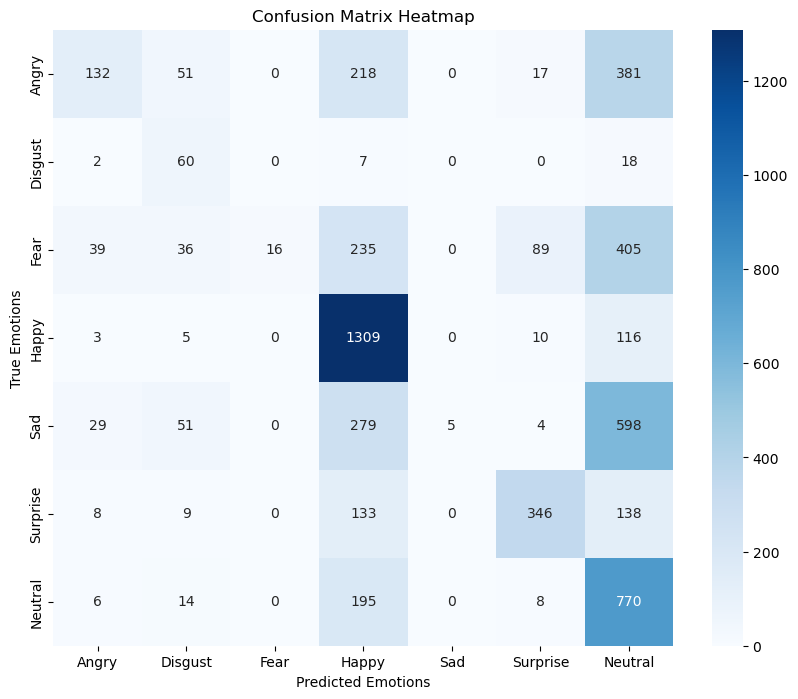

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

model = CNN()
model = model.to(device)
model_path = 'models/6_Group17_DLProject.pth'
model.load_state_dict(torch.load(model_path, weights_only=True))
model.eval()

# Initialize lists to store ground truth and predictions
y_true, y_pred = [], []

# Disable gradient computation
with torch.no_grad():
    for inputs, labels in val_loader:
        # Move inputs and labels to the same device as the model
        inputs, labels = inputs.to(device), labels.to(device)

        # Forward pass
        outputs = model(inputs)

        # Get the predicted class
        _, predicted = torch.max(outputs, 1)

        # Append ground truth and predictions to respective lists
        y_true.extend(labels.cpu().numpy())  # Convert tensors to numpy
        y_pred.extend(predicted.cpu().numpy())

# Generate the classification report
emotion_labels = {0:'Angry', 1:'Disgust', 2:'Fear', 3:'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}
emotion_names=list(emotion_labels.values())
print(classification_report(y_true, y_pred, target_names=emotion_names))

# Compute the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Create a heatmap visualization
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=emotion_names, yticklabels=emotion_names)
plt.title("Confusion Matrix Heatmap")
plt.xlabel("Predicted Emotions")
plt.ylabel("True Emotions")
plt.show()



The fine-tuned model performs poorly on Fear and Sad emotions, despite having been trained on these categories initially, because they were omitted during the fine-tuning process. As a result, the model likely lost critical features it had previously learned for these emotions, leading to poor recall and F1-scores for these classes. Moreover, the fine-tuning on GAN-generated images may have caused the model to overfit to the available data, particularly easier-to-classify emotions like Happy, while neglecting more challenging emotions like Fear and Sad. This lack of exposure during fine-tuning, combined with the low quality of the GAN images, hindered the model's ability to generalize effectively, resulting in worse overall performance. 

Compared to previous models, which likely trained on higher-quality data without the noise introduced by GAN images, the fine-tuned model’s metrics are significantly lower across the board. This suggests that the GAN-generated images, due to their poor quality and limited diversity, failed to improve the model’s robustness and instead degraded its ability to generalize to the full range of emotions.